# **Title:** Cross-Domain Sentiment Analysis: Evaluating Model Performance from Electronics to Cosmetics Product Reviews

## Part 04: Model 3 DistilBERT Fine-Tuning

## Import Necessary Libraries

In [2]:
!pip install transformers
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 34.7 MB/s eta 0:00:00


In [3]:
# Core Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import numpy as np
import random
import optuna

In [4]:
# Connect  to drive to load dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Cleaned Data Set

In [6]:
# Load cleaned dataset to train model

amazon_electronics_df = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Dataset/amazon_electronics_electronics_reviews_cleaned.csv')
sephora_skincare_df = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/Dataset/sephora_skincare_skincare_reviews_cleaned.csv')

In [ ]:
amazon_electronics_df.shape

(9991, 6)

In [ ]:
# Show loaded dataset

amazon_electronics_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,well trying box towersthat sounded like music ...,5,positive,194,0.153092,2
1,ordered one wife one reading negative review p...,5,positive,140,0.220424,2
2,muy buen producto full juegos fhd hay problema...,5,positive,24,0.350000,2
3,sound quality unit phenomenal bose sounddock w...,5,positive,93,0.268527,2
4,good keeping cpu cool also downt forget downlo...,4,positive,24,0.525000,2


In [ ]:
# Show loaded dataset

sephora_skincare_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,best eye serum ever used well worth money boug...,5,positive,81,0.036944,2
1,helped much stubborn texture purchase life,5,positive,12,0.312500,2
2,honestly not like product nothing seem make br...,2,negative,20,0.100000,0
3,okay started quarantine trying find skin routi...,5,positive,113,0.236111,2
4,good work wonder redness away almost immediate...,5,positive,16,0.562500,2


In [7]:
# Split amazon_electronics dataset into train (80%) and test (20%)

X_train, X_test, y_train, y_test = train_test_split(amazon_electronics_df['Review'],amazon_electronics_df['label'],train_size=0.80,random_state=50,stratify=amazon_electronics_df['label'])

print("Training set size:", len(X_train))
print("Validation set size:", len(X_test))


Training set size: 7992
Validation set size: 1999


In [8]:
# Prepare cross-domain test set (Sephora skincare reviews)

X_test_cross = sephora_skincare_df['Review']      # Text data for cross-domain testing
y_test_cross = sephora_skincare_df['label']       # Ground-truth sentiment labels

## Model 3 — DistilBERT Fine-Tuning

##  Tokenizing the text

In [ ]:
# Load the DistilBERT tokenizer (converts raw text into token IDs and attention masks)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the Amazon Electronics training set
# - truncation: cut longer texts to max_length
# - padding: pad shorter texts to uniform length
# - max_length: fixed sequence length used by DistilBERT

train_enc = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize validation data (same preprocessing for consistency)

val_enc = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize Sephora cross-domain test dataset

test_enc = tokenizer(
    list(X_test_cross),
    truncation=True,
    padding=True,
    max_length=128
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer outputs: input_ids + attention_mask

## Covert tokenized data + labels into a Pytorch dataset format

Required for DataLoader to batch and feed model

In [ ]:
# Custom Dataset class for handling tokenized inputs and labels for DistilBERT
class SentimentDataset(Dataset):

    def __init__(self, encodings, labels):
        """
        Store tokenized encodings (input_ids, attention_mask)
        and corresponding sentiment labels.

        Parameters
        ----------
        encodings : dict
            Output from the DistilBERT tokenizer (input_ids, attention_mask).
        labels : list or array
            List of integer sentiment labels.
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample by index.
        Converts tokenized inputs and labels into PyTorch tensors.

        Returns
        -------
        dict
            A dictionary containing:
            - input_ids
            - attention_mask
            - labels
        """
        # Convert each tokenized item to a tensor for PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # Add labels to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])

        return item


## Creating Dataset Objects

In [ ]:
# Create dataset objects for training, validation, and cross-domain testing
train_dataset = SentimentDataset(train_enc, list(y_train))
val_dataset   = SentimentDataset(val_enc, list(y_test))
test_dataset  = SentimentDataset(test_enc, list(y_test_cross))

## Selecting GPU or CPU

In [18]:
# Select computation device:
# - Use GPU (CUDA) if available for faster training
# - Otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading DistilBERT for Classification

In [ ]:
# Load pre-trained DistilBERT model for sequence classification
# num_labels=3 → because your sentiment task has 3 classes (negative, neutral, positive)

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

# Move the model to the selected device (GPU/CPU)
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Building DataLoaders

In [ ]:
# Create DataLoaders for batching and shuffling training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   # Shuffle for better learning
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)    # No shuffle for validation

## Defining the Optimizer

In [ ]:
# AdamW optimizer: recommended for transformer-based models
optimizer = AdamW(model.parameters(), lr=2e-5)   # Standard fine-tuning learning rate

## Training Loop (Fine-Tuning Model)

In [ ]:
# Training loop for DistilBERT
for epoch in range(3):   # Number of fine-tuning epochs
    model.train()        # Set model to training mode
    total_loss = 0

    # Iterate through each batch in the training DataLoader
    for batch in train_loader:

        optimizer.zero_grad()   # Reset gradients before each update

        # Move inputs and labels to GPU/CPU device
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward pass (model computes logits + loss)
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Extract training loss
        loss = outputs.loss

        # Backpropagation
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate loss for reporting
        total_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Training Loss: 0.5287
Epoch 2 - Training Loss: 0.3746
Epoch 3 - Training Loss: 0.2571


##  Save the trained model and tokenizer

In [ ]:
# Save DistilBERT model and tokenizer to Google Drive
save_dir = "/content/drive/MyDrive/distilbert_sentiment_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model_path = "/content/drive/MyDrive/Atikuzzaman/Model/distilbert_sentiment_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


## Evaluation (amazon_electronics)


=== amazon_electronics Validation Set Evaluation ===
Accuracy: 0.920
Weighted F1: 0.918

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       226
           1       0.68      0.50      0.58       178
           2       0.97      0.97      0.97      1595

    accuracy                           0.92      1999
   macro avg       0.80      0.80      0.79      1999
weighted avg       0.92      0.92      0.92      1999



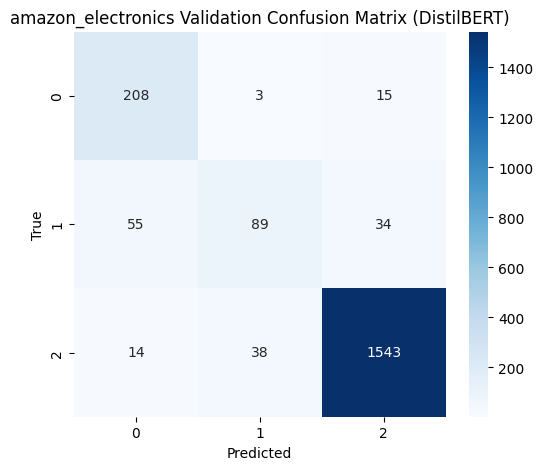

In [ ]:
# Set model to evaluation mode (disables dropout and gradient updates)
model.to(device)
model.eval()
val_preds, val_labels = [], []   # Lists to store predictions and true labels

# Disable gradient computation for faster inference and lower memory usage
with torch.no_grad():
    for batch in val_loader:

        # Move batch data to the selected device (GPU/CPU)
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward pass (no labels provided → no loss returned)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits                    # Raw output scores

        # Convert logits to predicted class indices
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Store predictions and true labels
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics for the Amazon Electronics validation set
val_acc = accuracy_score(val_labels, val_preds)
val_f1  = f1_score(val_labels, val_preds, average='weighted')

# Display results
print("\n=== amazon_electronics Validation Set Evaluation ===")
print(f"Accuracy: {val_acc:.3f}")
print(f"Weighted F1: {val_f1:.3f}")
print("\nClassification Report:")
print(classification_report(val_labels, val_preds))

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("amazon_electronics Validation Confusion Matrix (DistilBERT)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Cross-domain Evaluation (sephora_skincare)


=== sephora_skincare Cross-Domain Evaluation ===
Accuracy: 0.776
Weighted F1: 0.794

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       540
           1       0.20      0.29      0.23       415
           2       0.92      0.84      0.88      4033

    accuracy                           0.78      4988
   macro avg       0.54      0.60      0.56      4988
weighted avg       0.82      0.78      0.79      4988



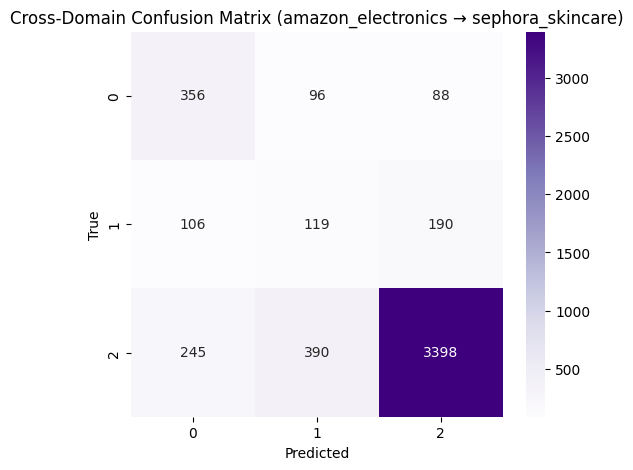

In [ ]:
# Prepare DataLoader for sephora_skincare test
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average='weighted')

print("\n=== sephora_skincare Cross-Domain Evaluation ===")
print(f"Accuracy: {test_acc:.3f}")
print(f"Weighted F1: {test_f1:.3f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Cross-Domain Confusion Matrix (amazon_electronics → sephora_skincare)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Comparison performance for cross domain shift

In [ ]:
amazon_electronics_acc = accuracy_score(val_labels, val_preds)
amazon_electronics_precision = precision_score(val_labels, val_preds, average='weighted')
amazon_electronics_recall = recall_score(val_labels, val_preds, average='weighted')
amazon_electronics_f1 = f1_score(val_labels, val_preds, average='weighted')

sephora_acc = accuracy_score(test_labels, test_preds)
sephora_precision = precision_score(test_labels, test_preds, average='weighted')
sephora_recall = recall_score(test_labels, test_preds, average='weighted')
sephora_f1 = f1_score(test_labels, test_preds, average='weighted')


# DistilBERT results
distilbert_results = pd.DataFrame({
    'Model': ['DistilBERT', 'DistilBERT'],
    'Dataset': ['amazon_electronics (In-domain)', 'sephora_skincare (Cross-domain)'],
     'Accuracy': [amazon_electronics_acc, sephora_acc],
    'Precision': [amazon_electronics_precision, sephora_precision],
    'Recall': [amazon_electronics_recall, sephora_recall],
    'F1-score': [amazon_electronics_f1, sephora_f1]
})


distilbert_results.to_csv("distilbert_results.csv", index=False)

print("\n=== Cross domain Comparison for  DistilBERT===")
distilbert_results



=== Cross domain Comparison for  DistilBERT===


,Model,Dataset,Accuracy,Precision,Recall,F1-score
0,DistilBERT,amazon_electronics (In-domain),0.920460,0.919196,0.920460,0.917575
1,DistilBERT,sephora_skincare (Cross-domain),0.776464,0.818272,0.776464,0.794009


## Hyperparameter Tuning
### Creating subsample to faster hyperparameter Tuning process

In [ ]:
import random, torch, numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [10]:
# Take 1000  dataset for amazon electronics

amazon_electronics_df_sm = amazon_electronics_df.sample(n=1000, random_state=42)

In [ ]:
amazon_electronics_df_sm.head()

,Review,Rating,sentiment,review_length,polarity,label
4023,bought cable three year ago still using connec...,5,positive,62,0.162103,2
7346,best headphone ive ever seen heard fifty buck ...,5,positive,29,0.512500,2
487,well say nikon supposed good read review ken r...,5,positive,293,0.228598,2
39,terrible use kept dropping signal within minut...,1,negative,20,-1.000000,0
6797,nikon listening bought camera ive generally go...,1,negative,177,0.002439,0


In [11]:
# Split amazon_electronics dataset into train (80%) and test (20%)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(amazon_electronics_df_sm['Review'],amazon_electronics_df_sm['label'],test_size=0.25,random_state=50,stratify=amazon_electronics_df_sm['label'])

print("Training set size:", len(X_train_sm))
print("Validation set size:", len(X_test_sm))


Training set size: 750
Validation set size: 250


In [12]:
# Take 1000  dataset for sephora electronics

sephora_skincare_df_sm = sephora_skincare_df.sample(n=1000, random_state=42)

In [ ]:
sephora_skincare_df_sm.head()

,Review,Rating,sentiment,review_length,polarity,label
1839,given positive review dermalogica thought eye ...,3,neutral,40,0.184943,1
1536,plump undereye skin crepey skin look like juic...,5,positive,152,0.112649,2
1662,lip balm smell amazing hydrating love natural ...,5,positive,39,0.495833,2
1075,impressed product super moisturizing not leave...,4,positive,79,0.246481,2
4201,love mask wait time minute many mask like resu...,5,positive,45,0.255000,2


In [13]:
# Prepare cross-domain test set (Sephora skincare reviews)

X_test_cross_sm = sephora_skincare_df_sm['Review']      # Text data for cross-domain testing
y_test_cross_sm = sephora_skincare_df_sm['label']       # Ground-truth sentiment labels

In [14]:
# Load the DistilBERT tokenizer (converts raw text into token IDs and attention masks)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the Amazon Electronics training set
# - truncation: cut longer texts to max_length
# - padding: pad shorter texts to uniform length
# - max_length: fixed sequence length used by DistilBERT

train_enc = tokenizer(
    list(X_train_sm),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize validation data (same preprocessing for consistency)

val_enc = tokenizer(
    list(X_test_sm),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize Sephora cross-domain test dataset

test_enc = tokenizer(
    list(X_test_cross_sm),
    truncation=True,
    padding=True,
    max_length=128
)

In [15]:
# Custom Dataset class for handling tokenized inputs and labels for DistilBERT
class SentimentDataset(Dataset):

    def __init__(self, encodings, labels):
        """
        Store tokenized encodings (input_ids, attention_mask)
        and corresponding sentiment labels.

        Parameters
        ----------
        encodings : dict
            Output from the DistilBERT tokenizer (input_ids, attention_mask).
        labels : list or array
            List of integer sentiment labels.
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample by index.
        Converts tokenized inputs and labels into PyTorch tensors.

        Returns
        -------
        dict
            A dictionary containing:
            - input_ids
            - attention_mask
            - labels
        """
        # Convert each tokenized item to a tensor for PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # Add labels to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])

        return item


In [16]:
# Create dataset objects for training, validation, and cross-domain testing
train_dataset = SentimentDataset(train_enc, list(y_train_sm))
val_dataset   = SentimentDataset(val_enc, list(y_test_sm))
test_dataset  = SentimentDataset(test_enc, list(y_test_cross_sm))

## Objective function for Optuna

In [ ]:
def objective(trial):
    # 1) Randomly sample hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = trial.suggest_int("num_epochs", 2, 5)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)

    # 2) Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    # 3) Load fresh model for each trial
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=3
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 4) Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    # 5) Validation
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)
            logits = model(input_ids, attention_mask=attention_mask).logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true.extend(labels.cpu().numpy())

    val_acc = accuracy_score(true, preds)
    return val_acc  # maximize accuracy

## Run Random Search (Optuna)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # try 10 random combinations

[I 2025-12-06 17:55:30,709] A new study created in memory with name: no-name-a3121f60-4f9c-4f04-b7e2-43961cb32a5d
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-06 17:55:55,567] Trial 0 finished with value: 0.776 and parameters: {'learning_rate': 3.370875797070377e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.09863500062917185}. Best is trial 0 with value: 0.776.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

Best hyperparameters: {'learning_rate': 1.431984772572435e-05, 'batch_size': 16, 'num_epochs': 3, 'weight_decay': 0.08741663466509485}
Best validation accuracy: 0.816


## Re-train model with Best Hyperparameter

## Loading DistilBERT for Classification

In [19]:
# Load pre-trained DistilBERT model for sequence classification
# num_labels=3 → because your sentiment task has 3 classes (negative, neutral, positive)

model_tuned = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

# Move the model to the selected device (GPU/CPU)
model_tuned.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Building DataLoaders

In [20]:
# Create DataLoaders for batching and shuffling training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   # Shuffle for better learning
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)    # No shuffle for validation

## Defining the Optimizer with best parameter

In [21]:
# Optimizer with weight decay
optimizer = AdamW(model_tuned.parameters(), lr=1.431984772572435e-05, weight_decay=0.08741663466509485)

## Training Loop (Fine-Tuning Model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Final Optimized Training Loop for DistilBERT (Train + Validate + Save Best Model)
best_val_acc = 0  # Track the best validation accuracy

for epoch in range(3):  # Adjust number of epochs as needed
    model.train()
    total_loss = 0

    # ------------------ TRAINING ------------------
    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to device
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward + loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backpropagation and update
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # ------------------ VALIDATION ------------------
    model.eval()
    val_labels = []
    val_preds  = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)

    # Save best-performing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_distilbert_model.pt")

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

print(f"\nBest Validation Accuracy Achieved: {best_val_acc:.4f}")

Epoch 1 | Train Loss: 0.2765 | Val Accuracy: 0.9280
Epoch 2 | Train Loss: 0.2788 | Val Accuracy: 0.9280
Epoch 3 | Train Loss: 0.2837 | Val Accuracy: 0.9280

Best Validation Accuracy Achieved: 0.9280


In [23]:
# Load the saved best model weights
best_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/Atikuzzaman/Model/best_distilbert_model.pt"))
best_model.to(device)
best_model.eval()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Evaluation (amazon_electronics)


=== Amazon Electronics Validation Set Evaluation ===
Accuracy: 0.928
Weighted F1: 0.926

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        32
           1       0.61      0.50      0.55        22
           2       0.98      0.97      0.98       196

    accuracy                           0.93       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.93      0.93      0.93       250



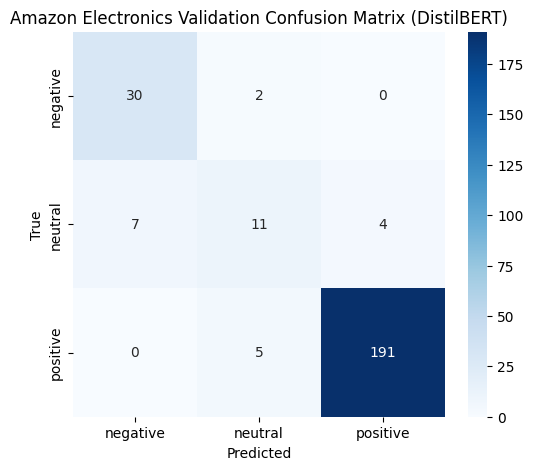

In [24]:
# Prepare lists for predictions and true labels
val_preds_best, val_labels_best = [], []

with torch.no_grad():
    for batch in val_loader:  # using Amazon Electronics validation set
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward pass
        outputs = best_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        # Append results to lists
        val_preds_best.extend(preds.cpu().numpy())
        val_labels_best.extend(labels.cpu().numpy())

# Compute metrics
val_acc = accuracy_score(val_labels_best, val_preds_best)
val_f1  = f1_score(val_labels_best, val_preds_best, average='weighted')

print("\n=== Amazon Electronics Validation Set Evaluation ===")
print(f"Accuracy: {val_acc:.3f}")
print(f"Weighted F1: {val_f1:.3f}")
print("\nClassification Report:")
print(classification_report(val_labels_best, val_preds_best))

# Confusion matrix
cm = confusion_matrix(val_labels_best, val_preds_best)
plt.figure(figsize=(6,5))
label_names = ["negative", "neutral", "positive"]  # adjust if your labels differ
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Amazon Electronics Validation Confusion Matrix (DistilBERT)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Cross-domain Evaluation (sephora_skincare)


=== Sephora Skincare Cross-Domain Evaluation ===
Accuracy: 0.783
Weighted F1: 0.798

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       120
           1       0.17      0.25      0.20        81
           2       0.92      0.86      0.89       799

    accuracy                           0.78      1000
   macro avg       0.56      0.58      0.57      1000
weighted avg       0.82      0.78      0.80      1000



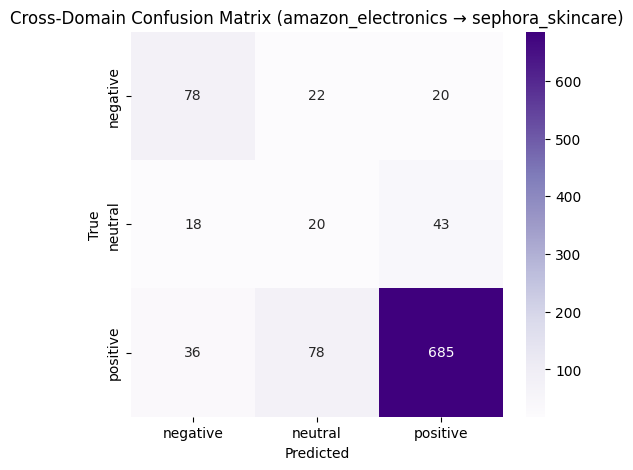

In [25]:
# Prepare DataLoader for Sephora skincare test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Set model to evaluation mode
best_model.eval()

# Lists to store predictions and true labels
test_preds_best, test_labels_best = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass using the best model
        outputs = best_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # Store results in lists
        test_preds_best.extend(preds.cpu().numpy())
        test_labels_best.extend(labels.cpu().numpy())

# Compute evaluation metrics
test_acc = accuracy_score(test_labels_best, test_preds_best)
test_f1  = f1_score(test_labels_best, test_preds_best, average='weighted')

print("\n=== Sephora Skincare Cross-Domain Evaluation ===")
print(f"Accuracy: {test_acc:.3f}")
print(f"Weighted F1: {test_f1:.3f}")
print("\nClassification Report:")
print(classification_report(test_labels_best, test_preds_best))

# Confusion matrix
cm = confusion_matrix(test_labels_best, test_preds_best)
plt.figure(figsize=(6,5))
label_names = ["negative", "neutral", "positive"]  # adjust if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=label_names, yticklabels=label_names)
plt.title("Cross-Domain Confusion Matrix (amazon_electronics → sephora_skincare)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [26]:
# Compute metrics for Amazon Electronics (in-domain)

amazon_electronics_acc       = accuracy_score(val_labels_best, val_preds_best)
amazon_electronics_precision = precision_score(val_labels_best, val_preds_best, average='weighted', zero_division=0)
amazon_electronics_recall    = recall_score(val_labels_best, val_preds_best, average='weighted', zero_division=0)
amazon_electronics_f1        = f1_score(val_labels_best, val_preds_best, average='weighted', zero_division=0)


# Compute metrics for Sephora Skincare (cross-domain)

sephora_acc       = accuracy_score(test_labels_best, test_preds_best)
sephora_precision = precision_score(test_labels_best, test_preds_best, average='weighted', zero_division=0)
sephora_recall    = recall_score(test_labels_best, test_preds_best, average='weighted', zero_division=0)
sephora_f1        = f1_score(test_labels_best, test_preds_best, average='weighted', zero_division=0)


# Compile results into a DataFrame

distilbert_results = pd.DataFrame({
    'Model': ['DistilBERT_tuned', 'DistilBERT_tuned'],
    'Dataset': ['amazon_electronics (In-domain)', 'sephora_skincare (Cross-domain)'],
    'Accuracy': [amazon_electronics_acc, sephora_acc],
    'Precision': [amazon_electronics_precision, sephora_precision],
    'Recall': [amazon_electronics_recall, sephora_recall],
    'F1-score': [amazon_electronics_f1, sephora_f1]
})


# Save results to CSV

distilbert_results.to_csv("distilbert_results_tuned.csv", index=False)


# Display results

print("\n=== Cross-Domain Comparison for DistilBERT ===")
display(distilbert_results)



=== Cross-Domain Comparison for DistilBERT ===


,Model,Dataset,Accuracy,Precision,Recall,F1-score
0,DistilBERT_tuned,amazon_electronics (In-domain),0.928,0.925480,0.928,0.925658
1,DistilBERT_tuned,sephora_skincare (Cross-domain),0.783,0.816114,0.783,0.797988
